### 透過實作深入了解word2vec模型

在前兩次的課程中，我們了解的word2vec的兩種模型(CBOW/Skip-gram)，接下來來看看如何實際搭建word2vec的模型。 本次課程講解會使用CBOW模型作為例子來進行。

### 搭建基礎層

由前面的課程可以學到，訓練word2vec模型時採用的神經網路為全連接層(FC)。在輸出層的部分則是採用softmax，損失函數使用cross entropy。

FC層的核心計算就是矩陣向量乘法。因此在開始搭建CBOW模型前，需要先搭建基本的FC層(矩陣乘法)與欲使用的softmax與cross entropy函數。

1. FC/Dense層: 損失函數對輸入的偏微分如下 (此部分計算有興趣的同學可以參考Appendix，本章節重點在於實作word2vec模型)

$$
\begin{aligned}
\frac{\partial{L}}{\partial{x}} &= \sum_j\frac{\partial{L}}{\partial{y}}W^T \\
\frac{\partial{L}}{\partial{W}} &= X^T \sum_j\frac{\partial{L}}{\partial{y}}
\end{aligned}
$$

2. Softmax & Loss層: 在訓練word2vec主要使用的輸出層函數為softmax，而使用的損失函數為cross entropy，其中偏微分如下

$$
\frac{\partial{L}}{\partial{SoftmaxIn}} = SoftmaxOut - \hat{y}
$$

In [1]:
import re
import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from utils.utility import clip_grads, remove_duplicate

In [2]:
# define softmax function
def softmax(x):
    if x.ndim == 2:
        x = np.exp(x)
        x = np.divide(x, x.sum(axis=1, keepdims=True) + 1e-7)
    elif x.ndim == 1:
        x = np.exp(x)
        x = np.divide(x, np.sum(x) + 1e-7)
        
    return x

# define cross entropy
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    if t.size == y.size:
        t = t.argmax(axis=1)
    
    batch_size = y.shape[0]
    
    return -(1/batch_size) * np.sum(np.log(y[np.arange(batch_size), t] + 1e-7))

# Define FC layer
class Dense():
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        w = self.params[0]
        out = np.dot(x, w)
        self.x = x
        
        return out
    
    def backward(self, dout):
        w = self.params[0]
        dx = np.dot(dout, w.T) #dx = dout * W^T
        dw = np.dot(self.x.T, dout) #dw = x^T * dout
        self.grads[0][...] = dw
        
        return dx
    
# define softmax with cross entropy layer
class SoftmaxWithCrossEntropy:
    def __init__(self):
        self.t = None
        self.y = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)
        
        loss = cross_entropy(self.y, self.t)
        
        return loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        dx = self.y.copy() #softmax output
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx /= batch_size
        
        return dx

### 資料前處理

除了建構搭建模型的基礎元素外，還需要將輸入的文本資料進行前置處理:

1. Tokenize: 將文本的字詞轉換為index
2. Data label pair: 將文本資料轉換為訓練資料與目標字詞的配對
3. One-hot encoding: 將訓練資料與目標字詞轉換為one-hot的形式

In [3]:
#define preprocess function
def preprocess(corpus: List[str], only_word: bool = False):
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    '''
    word_dic = set()
    processed_sentence = []
    
    for sentence in corpus:
        #將所有字詞轉為小寫
        sentence = sentence.lower()

        #移除標點符號(可以依據使用狀況決定是否要移除標點符號)
        if only_word:
            pattern = r'[^\W_]+'
            sentence = re.findall(pattern, sentence)
        else:
            punctuation_list = ['.', ',', '!', '?']
            for pun in punctuation_list:
                sentence = sentence.replace(pun, ' '+pun)
            sentence = sentence.split(' ')
        
        #添加字詞到字典中
        word_dic |= set(sentence)
        processed_sentence.append(sentence)
    
    
    #建立字詞ID清單
    word2idx = dict()
    idx2word = dict()
    for word in word_dic:
        if word not in word2idx:
            idx = len(word2idx)
            word2idx[word] = idx
            idx2word[idx] = word

    #將文本轉為ID型式
    id_mapping = lambda x: word2idx[x]
    
    corpus = np.array([list(map(id_mapping, sentence)) for sentence in processed_sentence])

    return corpus, word2idx, idx2word

In [4]:
# test preprocessing
text = "I am studying Natural Language Processing now."
corpus, word2idx, idx2word = preprocess([text])
corpus, word2idx, idx2word

(array([[0, 2, 6, 5, 4, 3, 7, 1]]),
 {'i': 0,
  '.': 1,
  'am': 2,
  'processing': 3,
  'language': 4,
  'natural': 5,
  'studying': 6,
  'now': 7},
 {0: 'i',
  1: '.',
  2: 'am',
  3: 'processing',
  4: 'language',
  5: 'natural',
  6: 'studying',
  7: 'now'})

In [5]:
# define function to create contexts - target
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = []
    targets = corpus[window_size:-window_size]

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(targets)

In [6]:
# test contexts target function
contexts, targets= create_contexts_target(corpus[0], window_size=2)
contexts, targets

(array([[0, 2, 5, 4],
        [2, 6, 4, 3],
        [6, 5, 3, 7],
        [5, 4, 7, 1]]),
 array([6, 5, 4, 3]))

In [7]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [8]:
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1],
         [0, 1, 0, 0, 0, 0, 0, 0]]], dtype=int32),
 array([[0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0]], dtype=int32))

### 搭建CBOW模型

在完成所以的前置作業(建構基本元素、資料前處理)後，可以開始搭建word2vec CBOW模型

In [9]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size
        
        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layers = [Dense(W_in) for i in range(window_size*2)]
        self.out_layer = Dense(W_out)
        self.loss_layer = SoftmaxWithCrossEntropy()


        layers = self.in_layers + [self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        hs = sum([self.in_layers[i].forward(contexts[:, i]) for i in range(self.window_size*2)])
        hs /= self.window_size*2
        
        score = self.out_layer.forward(hs)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da /= self.window_size*2
        
        for i in range(self.window_size*2):
            self.in_layers[i].backward(da)

        return None

### Trainer與Optimizer

搭建完模型後，最後一個步驟就是需要一個optimizer來針對由loss取得的gradient來更新模型的參數，optimizer像是模型參數的更新策略，這邊因為重點不在optimizer，因此會使用最單純好懂的SGD(Stochastic Gradient Descent)來當作optimizer

$$
W_t = W_{t-1} - \alpha\frac{\partial{L}}{\partial{W_{t-1}}}
$$

當所有都準備就緒後，就是串起資料、模型、optimizer來開始進行訓練了。

In [10]:
# define optimizer
class SGD:
    '''
    Stochastic Gradient Descent
    '''
    def __init__(self, lr=0.1):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]
            
# define trainer for training purpose
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        for epoch in tqdm.tqdm(range(max_epoch)):
            # shuffling
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # calculate loss and update weights
                loss = model.forward(batch_x, batch_t)
                model.backward()
                # remove duplicate weights (for weights sharing purpose)
                params, grads = remove_duplicate(model.params, model.grads) 
                # for gradient clipping purpose
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                    
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # evaluation
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    print(f"Epoch: {self.current_epoch+1}, Iteration: {iters+1}/{max_iters}, Loss: {avg_loss}")
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = list(range(len(self.loss_list)))
        
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel(f"iterations (x{self.eval_interval})")
        plt.ylabel(f"loss")
        plt.show()

### 開始訓練

一切準備就緒，可以開始訓練模型

In [11]:
# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# preprocess
text = 'You say goodbye and I say hello.'
corpus, word2idx, idx2word = preprocess([text])
contexts, target = create_contexts_target(corpus[0], window_size)
target = convert_one_hot(target, len(word2idx))
contexts = convert_one_hot(contexts, len(word2idx))

# define model
cbow_model = CBOW(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(cbow_model, sgd_optimizer)

# start training
trainer.fit(contexts, target, max_epoch, batch_size)

 28%|██▊       | 275/1000 [00:00<00:00, 1225.43it/s]

Epoch: 1, Iteration: 1/2, Loss: 1.945870612779989
Epoch: 2, Iteration: 1/2, Loss: 1.9456582499549633
Epoch: 3, Iteration: 1/2, Loss: 1.9458323664117319
Epoch: 4, Iteration: 1/2, Loss: 1.94571469856855
Epoch: 5, Iteration: 1/2, Loss: 1.9456842973942783
Epoch: 6, Iteration: 1/2, Loss: 1.945660996697967
Epoch: 7, Iteration: 1/2, Loss: 1.945710731817462
Epoch: 8, Iteration: 1/2, Loss: 1.9457377070785467
Epoch: 9, Iteration: 1/2, Loss: 1.9456168393699778
Epoch: 10, Iteration: 1/2, Loss: 1.945554628595425
Epoch: 11, Iteration: 1/2, Loss: 1.9456455456011217
Epoch: 12, Iteration: 1/2, Loss: 1.9454995615161328
Epoch: 13, Iteration: 1/2, Loss: 1.9455166585386874
Epoch: 14, Iteration: 1/2, Loss: 1.9454838517358568
Epoch: 15, Iteration: 1/2, Loss: 1.9455680895179488
Epoch: 16, Iteration: 1/2, Loss: 1.945392517408041
Epoch: 17, Iteration: 1/2, Loss: 1.945488623736027
Epoch: 18, Iteration: 1/2, Loss: 1.9453674349216723
Epoch: 19, Iteration: 1/2, Loss: 1.9453712254698472
Epoch: 20, Iteration: 1/2, Lo

 66%|██████▌   | 661/1000 [00:00<00:00, 1506.54it/s]

Epoch: 301, Iteration: 1/2, Loss: 0.43720092198979466
Epoch: 302, Iteration: 1/2, Loss: 0.555589279230305
Epoch: 303, Iteration: 1/2, Loss: 0.5694642058660747
Epoch: 304, Iteration: 1/2, Loss: 0.4559958262044751
Epoch: 305, Iteration: 1/2, Loss: 0.36030653145183955
Epoch: 306, Iteration: 1/2, Loss: 0.483617570298711
Epoch: 307, Iteration: 1/2, Loss: 0.45447971220063343
Epoch: 308, Iteration: 1/2, Loss: 0.35686423716750443
Epoch: 309, Iteration: 1/2, Loss: 0.530993688708382
Epoch: 310, Iteration: 1/2, Loss: 0.5417726380355752
Epoch: 311, Iteration: 1/2, Loss: 0.34148683018623865
Epoch: 312, Iteration: 1/2, Loss: 0.33801191051614454
Epoch: 313, Iteration: 1/2, Loss: 0.4179455344317061
Epoch: 314, Iteration: 1/2, Loss: 0.4923589418808176
Epoch: 315, Iteration: 1/2, Loss: 0.45977896848001726
Epoch: 316, Iteration: 1/2, Loss: 0.4028134323001852
Epoch: 317, Iteration: 1/2, Loss: 0.44495011179791866
Epoch: 318, Iteration: 1/2, Loss: 0.3154762900162595
Epoch: 319, Iteration: 1/2, Loss: 0.50309

100%|██████████| 1000/1000 [00:00<00:00, 1724.99it/s]

Epoch: 705, Iteration: 1/2, Loss: 0.4736139243513207
Epoch: 706, Iteration: 1/2, Loss: 0.24428668414757235
Epoch: 707, Iteration: 1/2, Loss: 0.13029436599717742
Epoch: 708, Iteration: 1/2, Loss: 0.26023224658764554
Epoch: 709, Iteration: 1/2, Loss: 0.2561712136039237
Epoch: 710, Iteration: 1/2, Loss: 0.25963373306102866
Epoch: 711, Iteration: 1/2, Loss: 0.26206986498745666
Epoch: 712, Iteration: 1/2, Loss: 0.25828389365469057
Epoch: 713, Iteration: 1/2, Loss: 0.2538408535760537
Epoch: 714, Iteration: 1/2, Loss: 0.26325288812135333
Epoch: 715, Iteration: 1/2, Loss: 0.3739009673950882
Epoch: 716, Iteration: 1/2, Loss: 0.12960032239510128
Epoch: 717, Iteration: 1/2, Loss: 0.2606491005927094
Epoch: 718, Iteration: 1/2, Loss: 0.25184712561661415
Epoch: 719, Iteration: 1/2, Loss: 0.26546721047229266
Epoch: 720, Iteration: 1/2, Loss: 0.2596349282072592
Epoch: 721, Iteration: 1/2, Loss: 0.2519196032569499
Epoch: 722, Iteration: 1/2, Loss: 0.26115956571079185
Epoch: 723, Iteration: 1/2, Loss: 0

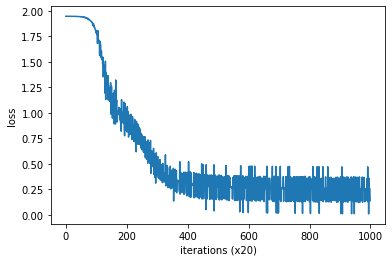

In [12]:
trainer.plot()

In [13]:
# check word2vec results
word_vecs = cbow_model.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

i [ 1.5014184   0.55395555  1.1085889  -1.1253431  -0.6633211 ]
say [-0.290205   -0.8290099  -2.147023    0.49414074 -0.77702194]
you [-0.42495802  1.3441554   2.0160549   0.17584291  1.9980527 ]
. [ 1.9007728   0.09555145 -1.1272005  -0.3289489  -1.6700785 ]
goodbye [ 1.5192126   0.5612364   1.084368   -1.1263704  -0.66816455]
and [-2.1903782  -0.93125004 -1.015991    0.8274492   0.9169905 ]
hello [-0.42036694  1.3293594   2.0003753   0.16550265  1.9935621 ]


### Appendix: Derivative Equation

1. **Softmax with Cross Entropy:**
$$
\begin{align}
Softmax &= \frac{e^{z_i}}{\sum_j^ke^{z_j}} \\
Cross\ Entropy &= -\frac{1}{N}\sum_j^N\sum_i^c(\hat{y_i}logy_i)
\end{align}
$$
在進行分類問題時，很常使用的output層函數是softmax，而此函數也經常與cross entropy的損失函數一起使用(學員可以參考此[文章](https://medium.com/jarvis-toward-intelligence/%E6%AF%94%E8%BC%83-cross-entropy-%E8%88%87-mean-squared-error-8bebc0255f5)了解為何分類為題常使用cross entropy當損失函數)。 在word2vec模型的訓練，也可以看成是一種分類問題(分類字詞)，因此訓練時的輸出層也是使用softmax與cross entropy。 相關的導函數推導可以參考此兩篇文章 [reference-1](https://medium.com/hoskiss-stand/backpropagation-with-softmax-cross-entropy-d60983b7b245), [reference-2](https://zhuanlan.zhihu.com/p/25723112)


2. **Dense layer:**

$$
y = xW
$$

在導函數的推導上，以舉例進行解說。

Ex:
$$
x= \left[
\begin{matrix}
    x_1&x_2&x_3
\end{matrix}
\right]
$$
$$
W= \left[
\begin{matrix}
    W_{11}&W_{12}&W_{13} \\
    W_{21}&W_{22}&W_{23} \\
    W_{31}&W_{32}&W_{331}
\end{matrix}
\right]
$$

$$
y = xW = \left[
\begin{matrix}
    W_{11}x_1+W_{21}x_2+W_{31}x_3&W_{12}x_1+W_{22}x_2+W_{32}x_3
\end{matrix}
\right]
$$

$$
\frac{\partial{y}}{\partial{x}} = \left[
\begin{matrix}
\frac{\partial{y_1}}{\partial{x_1}}&\frac{\partial{y_1}}{\partial{x_2}}&\frac{\partial{y_1}}{\partial{x_3}} \\
\frac{\partial{y_2}}{\partial{x_1}}&\frac{\partial{y_2}}{\partial{x_2}}&\frac{\partial{y_2}}{\partial{x_3}}
\end{matrix}
\right]
$$

$$
\frac{\partial{y}}{\partial{x}} = \left[
\begin{matrix}
    W_{11}&W_{21}&W_{31} \\
    W_{12}&W_{22}&W_{32}
\end{matrix}
\right] = W^T
$$

因此損失函數L對x的微分為
$$
\frac{\partial{L}}{\partial{x}} = \frac{\partial{L}}{\partial{y}}\frac{\partial{y}}{\partial{x}} = \frac{\partial{L}}{\partial{y}}W^T
$$

同理損失函數L對y的微分為
$$
\frac{\partial{L}}{\partial{W}} = x^T\frac{\partial{L}}{\partial{y}}
$$

對於矩陣微分想要更瞭解的學員可以參考此[文章](https://zhuanlan.zhihu.com/p/34826167)